### Download required libraries 

In [ ]:
!pip install opendatasets 
!pip install tensorboard
# !tensorboard --logdir=/content/outputs/


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import libraries

In [ ]:
import torch
from torch.functional import Tensor
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader,Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import ( 
    confusion_matrix, 
    ConfusionMatrixDisplay,
    precision_recall_fscore_support)

import numpy as np
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
import time
import os
import copy
from pathlib import Path
from collections import OrderedDict

# For visualizing the model architecture 
# import hiddenlayer as hl


# import torch.backends.cudnn as cudnn
# cudnn.benchmark = True
plt.ion()

device = ('cuda' if torch.cuda.is_available() else 'cpu')
cuda1 = torch.device(device)
num_workers = 0

### Download dataset

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset/download?datasetVersionNumber=3")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nimakam
Your Kaggle Key: ··········


100%|██████████| 663M/663M [00:19<00:00, 36.1MB/s]


In [ ]:
# Get the root path to dataset folder
d_path = "./tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database"
dataset_path = Path(d_path)

# Get the path to Normal and Tuberculosis data
n_data_path = dataset_path / "Normal"
t_data_path = dataset_path / "Tuberculosis"

## Functions

In [ ]:
import torch
import matplotlib
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
matplotlib.style.use('ggplot')

def show_plot(x,y,title='Number of cases',xlabel='Case type',ylabel='Count'
              ,xticks=['Normal(0)' ,"Tuberculosis(1)"]):
    plt.figure(figsize=(10,8))
    sns.barplot(x = x, y = y)
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(range(len(x)), xticks)
    plt.show()

def save_model(epochs, model, optimizer, criterion):
    """
    Save the trained model parameters to disk.
    """
    base_dir='./models'
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, base_dir+f'/model_{epochs}.pth')

def load_model(model,path='',opt= optim.Adam):
  """
  Load model state from file
  """
  dic = torch.load(path,device)
  model = model.load_state_dict(dic["model_state_dict"])
  # print (dic["model_state_dict"])
  return model , dic['loss'],dic['optimizer_state_dict']


def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Save the Loss and Accuracy plots to disk.
    """
    # base_dir="/content/drive/MyDrive/ai/Roshan Internship"
    base_dir="/content"

    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(base_dir+'/outputs/accuracy_.png')
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(base_dir+'/outputs/loss_.png')

# training
def train(model, trainloader, optimizer, criterion):
    """
    Train model for one epoch on dataloder
    """
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    preds_list=[]
    labels_list=[]
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data        
        image = image.to(device)
        labels = labels.to(device)
        # labels = labels.view(-1,1)
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = criterion(outputs.squeeze(), labels.float())
        train_running_loss += loss.item()
        # calculate the accuracy
        preds = torch.heaviside(outputs.data,torch.tensor([1.0]).to(device)).squeeze()
        train_running_correct += (preds == labels).sum().item()
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

# validation
def validate(model, testloader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    
    preds_list=[]
    labels_list=[]
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # labels = labels.view(-1,1)
            # forward pass
            outputs = model(image)
            # calculate the loss y_pred.squeeze()
            loss = criterion(outputs.squeeze(), labels.float())
            valid_running_loss += loss.item()
            # calculate the accuracy
            preds = torch.heaviside(outputs.data,torch.tensor([1.0]).to(device)).squeeze()
            # print(f"preds for output {(outputs.data.squeeze()).shape} are {preds.shape} \n"+
            # f"lables {labels.shape} are {(preds == labels).shape}")
            labels_list += (labels).tolist()
            preds_list += (preds).tolist()
            # print(preds.tolist())
            valid_running_correct += (preds == labels).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc ,preds_list, labels_list

def train_val_dataset(dataset, val_split=0.20,random_state=0):
    """
    split dataset into validation and train parts by the proportion of val_split
    """
    data_lables = [it[1] for it in dataset]
    train_idx, val_idx = train_test_split(
        list(range(len(dataset))),random_state=random_state, test_size=val_split,
         stratify=data_lables)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)

    datasets['val'] = Subset(dataset, val_idx)
    return datasets



## Load images

In [ ]:
# transform to Normalize images
transform = transforms.transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
# Get the list of all the images
data=datasets.ImageFolder(root=str(dataset_path),transform=transform)
# Split 600 images for testing
# del dataset
dataset=train_val_dataset(data,val_split=600)
train_count=np.unique([it[1] for it in dataset['train']],return_counts=True)
print("number of labels in train set is", train_count)
train_loader = DataLoader(
    dataset['train'], batch_size=18, shuffle=True,
    num_workers=num_workers, pin_memory=True
)
test_loader = DataLoader(
    dataset['val'], batch_size=30, shuffle=False,
    num_workers=num_workers, pin_memory=True)



number of labels in train set is (array([0, 1]), array([3000,  600]))


## Define model

In [ ]:
# Using alex net as feature extractor
model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
model.avgpool = nn.AdaptiveAvgPool2d(output_size=(15,15))
for param in model.parameters():
    param.requires_grad = False
# print(f"Initial model:\n{model}\n")
model.classifier = nn.Sequential(OrderedDict([
                          ('dropout1', nn.Dropout(p=0.05)),
                          ('fc1', nn.Linear(57600, 510)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(510, 1)),
                          # ('output', nn.Sigmoid())
                          ]))

model=model.to(device)
print(f"Updated model:\n{model}\n")
# Visualize model
from torchsummary import summary
summary(model,(3,512,512),batch_size=18)

Updated model:
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(15, 15))
  (classifier): Sequential(
    (dropout1): Dropout(p=0.05, inplace=False)
    (fc1): Linear(in_features=57600, out

### Training loop


In [ ]:
lr=0.0002
num_epochs = 4
cuda1 = torch.device(device)
class_weights = Tensor([5]) # for class 1 weight is 5 times of class 0
class_weights = class_weights.to(cuda1)
optimizer = optim.Adam(model.classifier.parameters(),lr=lr)
criterion = nn.BCEWithLogitsLoss()#pos_weight=class_weights)

# torch.cuda.is_available()
class_weights.get_device()


0

In [ ]:
# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# start the training
for epoch in range(num_epochs):
    print(f"[INFO]: Epoch {epoch+1} of {num_epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                              optimizer, criterion)
    (valid_epoch_loss, valid_epoch_acc,
     preds_list, labels_list) = validate(model, test_loader, criterion)
     
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    prec, rec, f1,_ =precision_recall_fscore_support(labels_list,preds_list)
    print(f"Training loss: {train_epoch_loss:.6f}, training acc: {train_epoch_acc:.6f}")
    print(f"Validation loss: {valid_epoch_loss:.6f}, validation acc: {valid_epoch_acc:.6f},")
    for l in [0,1]:
        print(f"for class[{l}]:\n validation precision: {prec[l]:.5f}, validation recall: {rec[l]:.5f} , validation F1: {f1[l]:.4f}")

    print('-'*50)
    time.sleep(4)
    
# save the trained model weights
# save_model(num_epochs, model, optimizer, criterion)

[INFO]: Epoch 1 of 4
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/20 [00:00<?, ?it/s]

Training loss: 0.054981, training acc: 98.750000
Validation loss: 0.016718, validation acc: 99.500000,
for class[0]:
 validation precision: 0.99601, validation recall: 0.99800 , validation F1: 0.9970
for class[1]:
 validation precision: 0.98990, validation recall: 0.98000 , validation F1: 0.9849
--------------------------------------------------
[INFO]: Epoch 2 of 4
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/20 [00:00<?, ?it/s]

Training loss: 0.005067, training acc: 99.861111
Validation loss: 0.014894, validation acc: 99.333333,
for class[0]:
 validation precision: 0.99402, validation recall: 0.99800 , validation F1: 0.9960
for class[1]:
 validation precision: 0.98980, validation recall: 0.97000 , validation F1: 0.9798
--------------------------------------------------
[INFO]: Epoch 3 of 4
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/20 [00:00<?, ?it/s]

Training loss: 0.000170, training acc: 100.000000
Validation loss: 0.016898, validation acc: 99.333333,
for class[0]:
 validation precision: 0.99402, validation recall: 0.99800 , validation F1: 0.9960
for class[1]:
 validation precision: 0.98980, validation recall: 0.97000 , validation F1: 0.9798
--------------------------------------------------
[INFO]: Epoch 4 of 4
Training


  0%|          | 0/200 [00:00<?, ?it/s]

Validation


  0%|          | 0/20 [00:00<?, ?it/s]

Training loss: 0.000089, training acc: 100.000000
Validation loss: 0.019457, validation acc: 99.333333,
for class[0]:
 validation precision: 0.99402, validation recall: 0.99800 , validation F1: 0.9960
for class[1]:
 validation precision: 0.98980, validation recall: 0.97000 , validation F1: 0.9798
--------------------------------------------------


Validation


  0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.019457, validation acc: 99.333333,
for class[0]:
 validation precision: 0.994024, validation recall: 0.998000 , validation F1: 0.996008
for class[1]:
 validation precision: 0.989796, validation recall: 0.970000 , validation F1: 0.979798


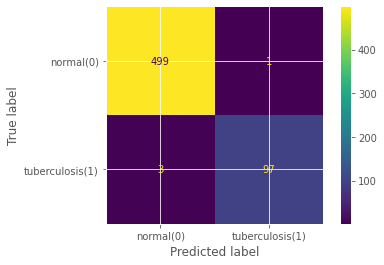

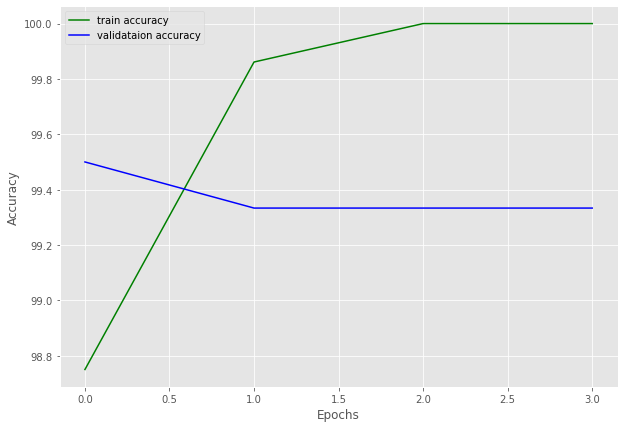

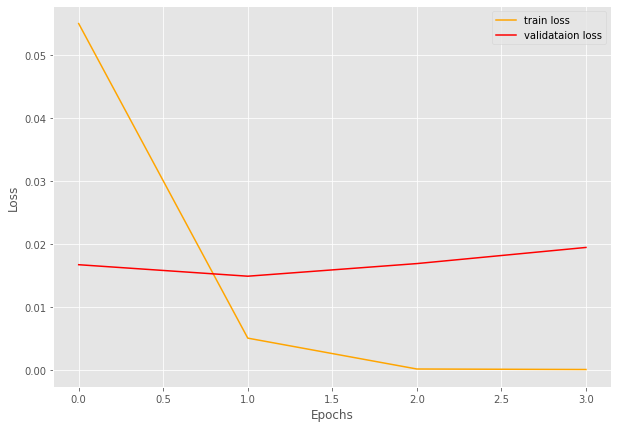

In [ ]:
valid_epoch_loss, valid_epoch_acc,preds,labels = validate(model, test_loader,  
                                                 criterion)
# print(labels,preds)
prec, rec, f1,_ =precision_recall_fscore_support(y_true=labels,y_pred=preds)
# print(prec,rec,f1)
print(f"Validation loss: {valid_epoch_loss:.6f}, validation acc: {valid_epoch_acc:.6f},")
for l in [0,1]:
  print(f"for class[{l}]:\n validation precision: {prec[l]:.6f}, validation recall: {rec[l]:.6f} , validation F1: {f1[l]:.6f}")

cm = confusion_matrix(labels, preds, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['normal(0)','tuberculosis(1)'])
disp.plot()
# save the trained model weights
# save_model(num_epochs, model, optimizer, criterion)

# save and show learning diagrams
save_plots(train_acc=train_acc,valid_acc=valid_acc
           ,train_loss=train_loss,valid_loss=valid_loss)

In [ ]:
# Load model from drive
# loaded_model,loaded_loss,opt_state_dict = load_model(model,'/content/model.pth')
# print(loaded_model)

model

<All keys matched successfully>


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(15, 15))
  (classifier): Sequential(
    (dropout1): Dropout(p=0.05, inplace=False)
    (fc1): Linear(in_features=57600, out_features=510, 